In [6]:
# import struct

# path = 'data/09020002.DAT'  # Update this to the actual path
# header = [0, 0, 0]  # Initialize header variable as a list of 3 integers
# arrays = [[], [], [], []]  # Initialize 4 arrays

# with open(path, mode='rb') as file:
#     # Read the first 3 bytes as header
#     header = list(struct.unpack('<3I', file.read(12)))

#     while True:
#         data = file.read(16)  # Reading 16 bytes at a time (4 bytes for each interval)
#         if not data:  # If data is empty
#             break

#         # Extract values manually without using struct.unpack
#         values = (
#             int.from_bytes(data[0:4], 'little'),
#             int.from_bytes(data[4:8], 'little'),
#             int.from_bytes(data[8:12], 'little'),
#             int.from_bytes(data[12:16], 'little')
#         )

#         # Add values to respective arrays
#         arrays[0].append(values[0])
#         arrays[1].append(values[1])
#         arrays[2].append(values[2])
#         arrays[3].append(values[3])

# # Print the header and the first few elements of each array
# print("Header:", header, len(header), type(header))
# print("Array1:", arrays[0][-1])
# print("Array2:", arrays[1][:5])
# print("Array3:", arrays[2][:5])
# print("Array4:", arrays[3][:5])
# print("Array3:", len(arrays[2]), type(arrays[2]))
# print("Array4:", len(arrays[3]), type(arrays[3]))


Header: [100, 500, 20] 3 <class 'list'>
Array1: 356716768
Array2: [351720451, 351723937, 351727420, 351730911, 351734402]
Array3: [851, 854, 862, 870, 876]
Array4: [40939, 40920, 40940, 40940, 40947]
Array3: 1399 <class 'list'>
Array4: 1399 <class 'list'>


In [2]:
# import numpy as np

# t1 = np.array(arrays[0])
# t2 = np.array(arrays[1])

# t_sampling = t2 - t1
# t_sampling_med = np.median(t_sampling)
# print(t_sampling_med)

# t_gap = t1[1:]  - t2[:-1] 
# print(t_gap[0:5])
# print(np.median(t_gap))

# gap_index_L = np.where( t_gap > np.median(t_gap) + 1000 )
# gap_index_L = gap_index_L[0]
# print(gap_index_L[0:5])

# t = (t1+t2)/2

# dt = t - np.roll(t,1)
# # skip 1st value
# dt = dt[1:]
# print(np.median(dt))



2951.0
[535 534 535 535 535]
535.0
[ 31  63  95 127 159]
3485.5


Time spent sampling
[2947 2951 2949 2956 2956]
2951.0
Gaps
[535 534 535 535 535]
535.0
indices
31
[59, 90, 121, 152, 183]
bytes
[960, 496, 496, 496, 496]
check
True


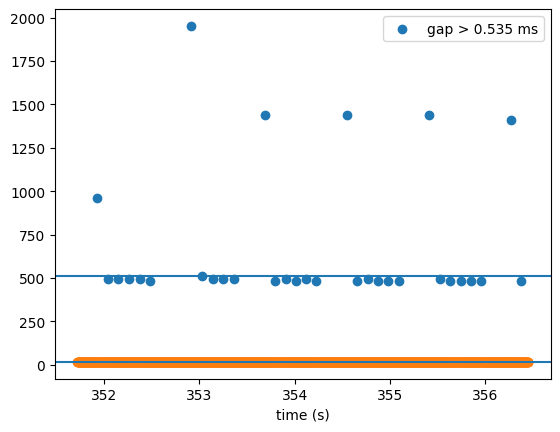

In [42]:

# import numpy as np

# tB4 = np.array(arrays[0])
# tAfter = np.array(arrays[1])

# t_sampling = tAfter - tB4
# t_sampling_med = np.median(t_sampling)
# print('Time spent sampling')
# print(t_sampling[0:5])
# print(t_sampling_med)

# t_gap = tB4[1:]  - tAfter[:-1] 
# print('Gaps')
# print(t_gap[0:5])
# print(np.median(t_gap))
# t_gap_med = np.median(t_gap)

# t2_index_L = []
# none_index = []
# index = 0 

# for t1,t2 in zip(tB4[1:], tAfter[:-1]): 
    
#     t_gap = t1 - t2
#     # print(t_gap)
#     if t_gap >  t_gap_med+t_sampling_med: 
#         t2_index_L.append(index)
#         index += 1
#         # continue
#     elif t_gap <= t_gap_med and t_gap > 0:
#         # t2_index_L.append(index)
#         none_index.append(index)
#         index += 1
#         # continue
#     elif t_gap < 0: 
#         print(t_gap)
# print('indices')
# print(len(t2_index_L))
# print(t2_index_L[0:5])

# # t2_new = []
# # for i in t2_index_L: 
# #     t2_new.append()

# # t2_times = []
# # for i in t2_index_L: 
# #     t2_times.append(tAfter[i])

# # print(t2_times[0:5])
# # print(len(t2_times))
# # print(t2_times[1] - t2_times[0])

# bytes_l = []
# # for i,arr in zip(range(len(t2_index_L)), t2_index_L):
# #     bytes_l.append()
# # print('test')
# temp = 0 
# for arr in t2_index_L: 
#     bytes_l.append((arr+1-temp)*16)
#     temp = arr + 1

#     # print(temp)

# other_l = []
# temp_other = 0 
# for other in none_index:
#     other_l.append((other+1-other)*16)
#     temp_other = other + 1
    
# print('bytes')
# print(bytes_l[0:5])

# print('check')
# print(len(tAfter[none_index])==len(other_l))

# import matplotlib.pyplot as plt 

# plt.scatter(np.array(tAfter[t2_index_L])/1e6,np.array(bytes_l), label = f'gap > {t_gap_med/1e3} ms')
# plt.scatter(np.array(tAfter[none_index])/1e6,np.array(other_l))
# plt.axhline(y=512)
# plt.axhline(y=16)
# plt.xlabel('time (s)')
# plt.legend()

In [2]:
import struct

path = 'data/09020001.DAT'  # Update this to the actual path
# header = [0, 0, 0]  # Initialize header variable as a list of 3 integers
arrays = [[], [], [], []]  # Initialize 4 arrays
# print(header)
with open(path, mode='rb') as file:
    # Read the first 3 bytes as header
    header = list(struct.unpack('<3I', file.read(12)))

    while True:
        data = file.read(16)  # Reading 16 bytes at a time (4 bytes for each interval)
        if not data:  # If data is empty
            break

        # Extract values using struct.unpack
        values = struct.unpack('<4I', data)

        # Extract values manually without using struct.unpack
        # values = (
        #     int.from_bytes(data[0:4], 'little'),
        #     int.from_bytes(data[4:8], 'little'),
        #     int.from_bytes(data[8:12], 'little'),
        #     int.from_bytes(data[12:16], 'little')
        # )

        # Add values to respective arrays
        arrays[0].append(values[0])
        arrays[1].append(values[1])
        arrays[2].append(values[2])
        arrays[3].append(values[3])

print("Header:", header, len(header), type(header))
import numpy as np
print("time1:", np.array(arrays[0][:5]))
print("time2:", np.array(arrays[1][:5]))
print("A0:", arrays[2][:5])
print("A1:", arrays[3][:5])

print("Array3:", len(arrays[2]), type(arrays[2]))
print("Array4:", len(arrays[3]), type(arrays[3]))

Header: [100, 500, 20] 3 <class 'list'>
time1: [346692103 346695592 346699085 346702568 346706056]
time2: [346695057 346698550 346702033 346705522 346709008]
A0: [845, 863, 850, 859, 866]
A1: [40918, 40918, 40920, 40929, 40940]
Array3: 1399 <class 'list'>
Array4: 1399 <class 'list'>


t2 [346.695057 346.69855  346.702033 346.705522 346.709008]
Expected time spent sampling (us):  2000
median time spent sampling (us):  2951.0

Expected gap, no overhead (us):  500
median gap (us):  535.0
largest gap (ms):  3.592
smallest gap (us):  534

no gap, expected number of bytes sent:  16
Expected byte chunk due to SD write:  512
Expected # of lines written per chunk:  32.0
one time [346692103, 346695057, 346695592, 346698550, 346699085]
jumps, len(jumps) [63, 127, 191, 255] 43
old indices, len [ 31  63  95 127] 43
Did we collect all the indices: True
jump bytes: [512.0, 512.0, 512.0, 512.0]
old bytes: [512, 512, 512, 512]
Did we collect the correct number of elements:  True
Did we collect the correct number of elements:  True

Large list 
len of bytes:  43
median byte:  512.0
largest byt :  512

Small list
len of bytes:  1355
median byte:  16.0
largest byte:  32


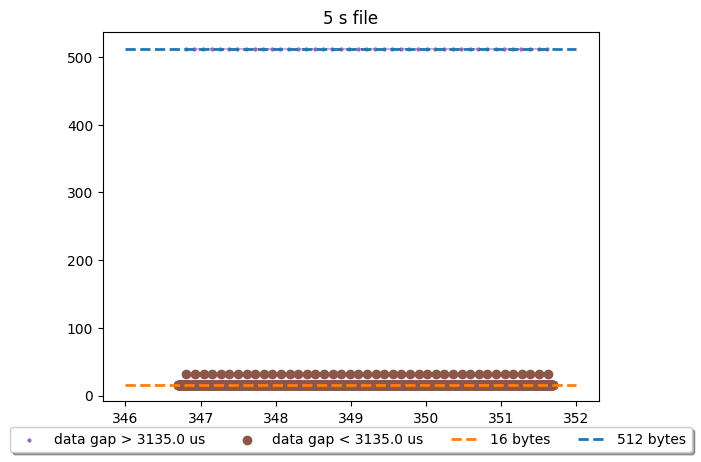

In [10]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

t1 = np.array(arrays[0]) # time before data collection 
t2 = np.array(arrays[1]) # time after data collection 
print('t2', t2[0:5]/1e6)
# Expected sample rate 
inter_sample = header[0]
inter_average = header[1]
samples_averaged = header[2]
print('Expected time spent sampling (us): ', samples_averaged*inter_sample)

# Time spent sampling 
t_s = t2 - t1 
t_s_med = np.median(t_s) # 2000 us
print("median time spent sampling (us): ", t_s_med)

# Expected gap 
print("\nExpected gap, no overhead (us): ", inter_average)

# Gaps 
t_g = t1[1:] - t2[:-1]
t_g_med = np.median(t_g) # 500 us
print("median gap (us): ", t_g_med)
print("largest gap (ms): ", max(t_g/1e3))
print("smallest gap (us): ", min(t_g))

# no gap number of bytes 
print('\nno gap, expected number of bytes sent: ', 16)
# Expected large gap
print("Expected byte chunk due to SD write: ", 512)
print("Expected # of lines written per chunk: ", 512/16)


# collect t2 indices with large gaps 
# -------t2           t1-------------t2       t1-------------t2 
indices_t2_L = [] # collect large gaps
indices_t2_S = [] # collect small gaps (all others)
index = 0 
# between ~ 2600 - 3000 shows large bytes 
condition = t_g_med + 2600  # t_g_med = 500
# condition = t_s_med + 500 # t_s_med = 2000

t = []
for i in range(len(t2)):
    t.append(t1[i])
    t.append(t2[i])
print("one time",t[0:5])
t = np.array(t)

jumps = []
for i in range(len(t)-1): 
    if t[i+1] - t[i] > condition: 
        jumps.append(i)
print('jumps, len(jumps)', jumps[0:4], len(jumps))

for t_1,t_2 in zip( t1[1:] , t2[:-1] ):
    
    # check how large the gap is and collect it accordingly
    t_gap = (t_1 - t_2)

    if t_gap >= condition: 
        indices_t2_L.append(index)
        index += 1
        # print('tgap, condition', t_gap, condition)

    elif t_gap < condition:
        indices_t2_S.append(index)
        index += 1
    else: 
        print("why")


# Create Arrays 
jumps = np.array(jumps)
indices_t2_L = np.array(indices_t2_L)
print('old indices, len', indices_t2_L[0:4], len(indices_t2_L))
indices_t2_S = np.array(indices_t2_S)
print("Did we collect all the indices:", len(t2) - 1 == (len(indices_t2_L) + len(indices_t2_S)))

# Calculate the number of bytes 
#   (current_index + 1) - previous_index = number of lines 
#   number of lines x 16  = # of bytes sent
jumps_L = []
temp_j = 0
for i in jumps: 
    jumps_L.append( (i + 1 - temp_j) * 16/2)
    temp_j = i + 1
print("jump bytes:", jumps_L[0:4])

bytes_L = []
temp_L = 0
for i in indices_t2_L: 
    bytes_L.append( (i + 1 - temp_L) * 16)
    temp_L = i + 1
print("old bytes:", bytes_L[0:4])

bytes_S = []
temp_S = 0
for i in indices_t2_S: 
    bytes_S.append( (i + 1 - temp_S) * 16)
    temp_S = i + 1

# Create arrays 
jumps_L = np.array(jumps_L)
bytes_L = np.array(bytes_L)
bytes_S = np.array(bytes_S)
print("Did we collect the correct number of elements: ", len(t2) - 1 == (len(bytes_L) + len(bytes_S)))
print("Did we collect the correct number of elements: ", len(jumps) == (len(jumps_L) ))
print('\nLarge list ')
print("len of bytes: ", len(bytes_L))
print("median byte: ", np.median(bytes_L))
print("largest byt : ", max(bytes_L))
print('\nSmall list')
print("len of bytes: ", len(bytes_S))
print("median byte: ", np.median(bytes_S))
print("largest byte: ", max(bytes_S))



plt.plot(t[jumps]/1e6, jumps_L, color = 'C4', alpha=0.5)
plt.scatter(t[jumps]/1e6, jumps_L, color = 'C4', s=4, label = f'data gap > {condition} us')
# plt.plot(t2[indices_t2_L]/1e6, bytes_L, color = 'C4', alpha=0.5)
# plt.scatter(t2[indices_t2_L]/1e6, bytes_L, color = 'C4', s=4, label = f'data gap > {condition} us')
plt.scatter(t2[indices_t2_S]/1e6, bytes_S, label = f'data gap < {condition} us', color = 'C5')
plt.hlines(y=16.0, xmin=346, xmax=352, colors='tab:orange', ls='--', lw=2, label="16 bytes")
plt.hlines(y=512.0, xmin=346, xmax=352, colors='tab:blue', ls='--', lw=2, label="512 bytes")


plt.xlabel('time (s)')
plt.title(f'{round((t2[indices_t2_S][-1] - t2[indices_t2_S][0])/1e6)} s file')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)


In [ ]:
fig, axs = plt.subplots(1)
fig.set_size_inches(8,8)

t = (t1 + t2)/2
v0 = np.array(arrays[2])
axs[0].scatter(t,v0,s=4)
axs[0].plot(t,v0,alpha=0.5, label ='A0')
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Volts')
axs[0].set_title('A0')
axs[0].legend()
axs[0].grid()
